## Spark Data Exploration & Analysis

## Learning Outcomes

In this assignment, you will do the following:

* Import a dataset into the Databricks Spark environment

* Create tables for the data imported

* Perform basic data analysis using transformations and Spark SQL

##Recommended Readings & Resources:

A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets.
Dataset source from GitHub and Guide on importing data to Databricks.
Sample notebook with preliminary data exploration. Ensure to attach the imported notebook to a cluster before execution.

##Analysis Tasks:

####1 Differentiate between RDDs, Dataframes, and Datasets.
####2 Analyze the dataset to:
      Identify the count of sensor pads from Poland.
      Determine the distinct LCD colors present.
      List the top 5 countries with the most MAC devices.
      Propose and implement a statistical test or model to glean insights from the dataset, leveraging any combination of SparkSQL, Python visualization libraries, correlation functions, or Spark functions.

In this notebook, we will import a dataset into Spark, create tables, and conduct some initial data analysis. The analysis will include basic data exploration and specific tasks mentioned in the assignment.


####For advanced exploration, you can refer to MLLib for implementing machine learning models.


### Q1: Explain the main differences between RDDs, Dataframes and Datasets (4 marks)

#####RDDs, or Resilient Distributed Datasets, are the fundamental logical abstraction in Spark. They are distributed collections of data that can be processed in parallel. RDDs are resilient because they can be reconstructed at any point during execution, and transformations on RDDs don't alter the original RDD.

#####DataFrames are similar to RDDs but offer higher-level functionality. They represent data in a tabular format with a schema, consisting of rows and columns. DataFrames are faster than RDDs due to Spark's Catalyst Optimizer, which optimizes execution plans.

#####Datasets combine the best of RDDs and DataFrames. They are collections of strongly-typed JVM objects, stored in Spark's optimized binary format. Datasets offer resilience, type safety, and efficient processing with serialization and improved memory utilization.


In [0]:
%pip install tabulate

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Data Import and Overview & Load JSON data into DataFrame
df = spark.read.json("/FileStore/tables/dmatrix_examples_master_spark_databricks_notebooks_py_data.json")

# Verify the data loaded correctly
df.show()


+-------------+---------+----+----+-------------+---------+--------------------+--------+---------------+--------+------+---------+-------+----+-------------+
|battery_level|c02_level|cca2|cca3|           cn|device_id|         device_name|humidity|             ip|latitude|   lcd|longitude|  scale|temp|    timestamp|
+-------------+---------+----+----+-------------+---------+--------------------+--------+---------------+--------+------+---------+-------+----+-------------+
|            8|      868|  US| USA|United States|        1|meter-gauge-1xbYRYcj|      51|   68.161.225.1|    38.0| green|    -97.0|Celsius|  34|1458444054093|
|            7|     1473|  NO| NOR|       Norway|        2|   sensor-pad-2n2Pea|      70|  213.161.254.1|   62.47|   red|     6.15|Celsius|  11|1458444054119|
|            2|     1556|  IT| ITA|        Italy|        3| device-mac-36TWSKiT|      44|      88.36.5.1|   42.83|   red|    12.83|Celsius|  19|1458444054120|
|            6|     1080|  US| USA|United Stat

In [0]:
df.createOrReplaceTempView("iot_devices")


In [0]:
result = spark.sql("SELECT COUNT(*) as devices_from_poland FROM iot_devices WHERE cca2 = 'PL' OR cca3 = 'POL'")
result.show()


+-------------------+
|devices_from_poland|
+-------------------+
|               2744|
+-------------------+



#####Observation:  There are 2744 sensor pads reported to be from Poland in the dataset.

In [0]:
result = spark.sql("SELECT COUNT(DISTINCT lcd) as distinct_lcd_colors FROM iot_devices")
result.show()


+-------------------+
|distinct_lcd_colors|
+-------------------+
|                  3|
+-------------------+



#####Observation: There are 3 distinct LCD colors in the dataset.

In [0]:
result_mac = spark.sql("""
    SELECT cca3 as country, COUNT(device_id) as mac_device_count 
    FROM iot_devices 
    WHERE LOWER(device_name) LIKE '%mac%'  
    GROUP BY cca3 
    ORDER BY mac_device_count DESC 
    LIMIT 5
""")
result_mac.show()


+-------+----------------+
|country|mac_device_count|
+-------+----------------+
|    USA|           11843|
|    CHN|            2302|
|    JPN|            2003|
|    KOR|            2000|
|    DEU|            1316|
+-------+----------------+



#####Observation: The USA, CHN, JPN, KOR, and DEU have the highest number of MAC devices in use

In [0]:
df.printSchema()  # prints the schema in a tree format
print(df.dtypes)  # prints column names along with their data types

root
 |-- battery_level: long (nullable = true)
 |-- c02_level: long (nullable = true)
 |-- cca2: string (nullable = true)
 |-- cca3: string (nullable = true)
 |-- cn: string (nullable = true)
 |-- device_id: long (nullable = true)
 |-- device_name: string (nullable = true)
 |-- humidity: long (nullable = true)
 |-- ip: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- lcd: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- scale: string (nullable = true)
 |-- temp: long (nullable = true)
 |-- timestamp: long (nullable = true)

[('battery_level', 'bigint'), ('c02_level', 'bigint'), ('cca2', 'string'), ('cca3', 'string'), ('cn', 'string'), ('device_id', 'bigint'), ('device_name', 'string'), ('humidity', 'bigint'), ('ip', 'string'), ('latitude', 'double'), ('lcd', 'string'), ('longitude', 'double'), ('scale', 'string'), ('temp', 'bigint'), ('timestamp', 'bigint')]


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Define the feature columns to be used in the clustering
feature_cols = ['battery_level', 'c02_level', 'humidity', 'temp']

# Assemble the columns into a feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_kmeans = assembler.transform(df)

# Initialize an empty list to hold the cost of each k
cost = list()

for k in range(2,10):  # k from 2 to 10
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.select('features'))
    c = model.summary.trainingCost
    print(f"The cost for k={k} is {c}")
    cost.append(c)


The cost for k=2 is 2748082073.100136
The cost for k=3 is 1275429688.7575967
The cost for k=4 is 767464196.7325525
The cost for k=5 is 527731125.4190378
The cost for k=6 is 400501843.54793906
The cost for k=7 is 341060040.47349447
The cost for k=8 is 270840593.4272817
The cost for k=9 is 235917308.27329338


###Based on the Elbow Method, it can be inferred that k=4 could be a reasonable choice. At this point, the cost reduction is still significant, but the subsequent improvement for higher values of k becomes less pronounced. Selecting k=4 strikes a balance between capturing meaningful cluster structure while avoiding excessive complexity.

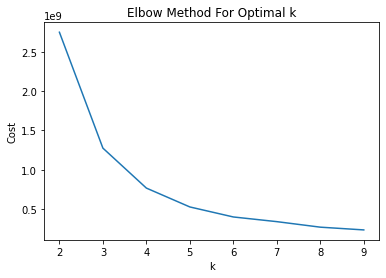

In [0]:
import matplotlib.pyplot as plt

k_values = list(range(2, 10))
plt.plot(k_values, cost)
plt.xlabel("k")
plt.ylabel("Cost")
plt.title("Elbow Method For Optimal k")
plt.show()

In [0]:
# KMeans
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans.select('features'))

# Get the cluster centers
centers = model.clusterCenters()

# Print the cluster centers
for i, center in enumerate(centers):
    print(f"Cluster center {i}: {center}")


Cluster center 0: [   4.50224823 1501.6556411    62.07436608   22.01956678]
Cluster center 1: [  4.5076127  901.56791959  61.8538123   21.97856945]
Cluster center 2: [   4.491557   1103.92736815   62.00572882   21.99038519]
Cluster center 3: [   4.49759645 1304.102925     62.03882348   22.06399967]


In [0]:
# Transform the data to include cluster assignments
df_kmeans = model.transform(df_kmeans)

# See the cluster assignments
df_kmeans.show()


+-------------+---------+----+----+-------------+---------+--------------------+--------+---------------+--------+------+---------+-------+----+-------------+--------------------+----------+
|battery_level|c02_level|cca2|cca3|           cn|device_id|         device_name|humidity|             ip|latitude|   lcd|longitude|  scale|temp|    timestamp|            features|prediction|
+-------------+---------+----+----+-------------+---------+--------------------+--------+---------------+--------+------+---------+-------+----+-------------+--------------------+----------+
|            8|      868|  US| USA|United States|        1|meter-gauge-1xbYRYcj|      51|   68.161.225.1|    38.0| green|    -97.0|Celsius|  34|1458444054093|[8.0,868.0,51.0,3...|         1|
|            7|     1473|  NO| NOR|       Norway|        2|   sensor-pad-2n2Pea|      70|  213.161.254.1|   62.47|   red|     6.15|Celsius|  11|1458444054119|[7.0,1473.0,70.0,...|         0|
|            2|     1556|  IT| ITA|        It

In [0]:
df_kmeans.printSchema()  # prints the schema in a tree format
print(df_kmeans.dtypes)  # prints column names along with their data types

root
 |-- battery_level: long (nullable = true)
 |-- c02_level: long (nullable = true)
 |-- cca2: string (nullable = true)
 |-- cca3: string (nullable = true)
 |-- cn: string (nullable = true)
 |-- device_id: long (nullable = true)
 |-- device_name: string (nullable = true)
 |-- humidity: long (nullable = true)
 |-- ip: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- lcd: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- scale: string (nullable = true)
 |-- temp: long (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)

[('battery_level', 'bigint'), ('c02_level', 'bigint'), ('cca2', 'string'), ('cca3', 'string'), ('cn', 'string'), ('device_id', 'bigint'), ('device_name', 'string'), ('humidity', 'bigint'), ('ip', 'string'), ('latitude', 'double'), ('lcd', 'string'), ('longitude', 'double'), ('scale', 'string'), ('temp', 'bigint'), ('timestamp', 'bigint'), (

In [0]:
print(type(df_kmeans))


<class 'pyspark.sql.dataframe.DataFrame'>


In [0]:
# Import ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Compute Silhouette score
silhouette = evaluator.evaluate(df_kmeans)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Count the number of data points in each cluster
cluster_sizes = df_kmeans.groupBy('prediction').count().orderBy('prediction')
cluster_sizes.show()



Silhouette with squared euclidean distance = 0.7102418023860484
+----------+-----+
|prediction|count|
+----------+-----+
|         0|48942|
|         1|50206|
|         2|50159|
|         3|48857|
+----------+-----+



### The Silhouette score indicates a good clustering quality, while the relatively balanced distribution of data points among the four clusters supports the choice of 4 clusters as a reasonable configuration for the dataset.

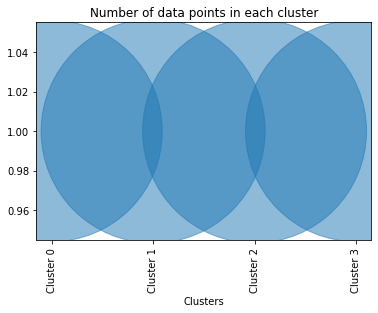

In [0]:
import matplotlib.pyplot as plt

# Define cluster names and their corresponding counts
clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
counts = [48942, 50206, 50159, 48857]

# Create a scatter plot where the size of each point is proportional to the count
plt.scatter(clusters, [1]*len(clusters), s=counts, alpha=0.5)
plt.xlabel('Clusters')
plt.xticks(rotation='vertical')
plt.title('Number of data points in each cluster')
plt.show()



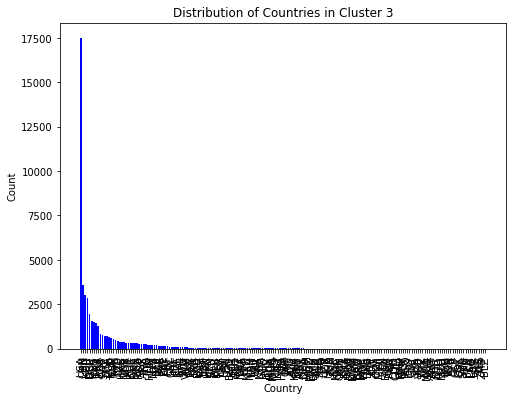

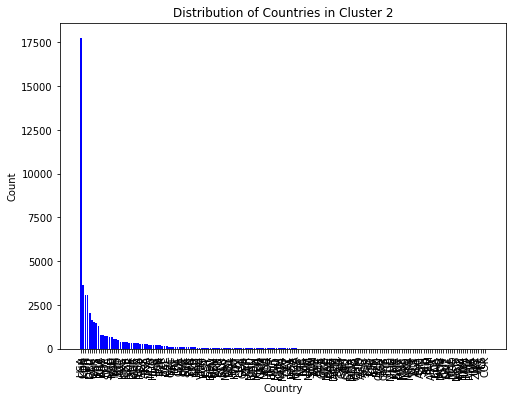

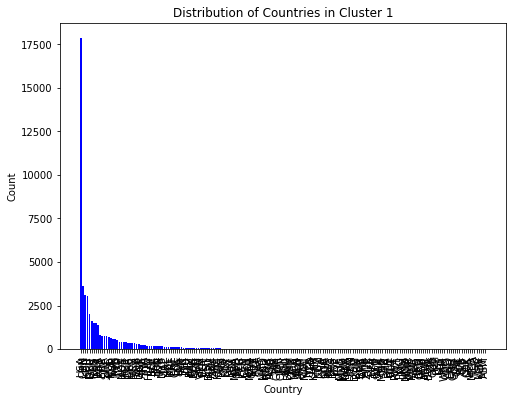

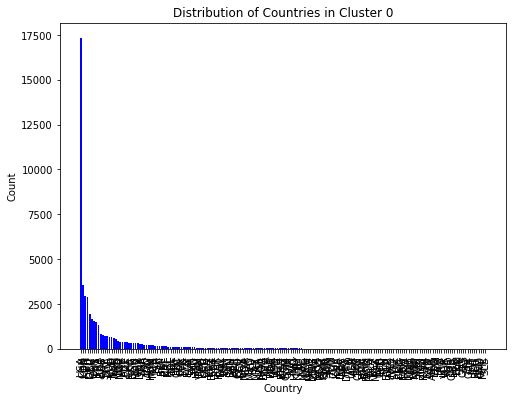

In [0]:
from pyspark.sql.functions import desc

# Group data points by cluster and 'cca3' variable
cluster_profile = df_kmeans.groupby('prediction', 'cca3').count().sort(desc('prediction'))

# Collect the data to the driver node and convert it to Pandas DataFrame
cluster_profile = cluster_profile.toPandas()

# Create separate lists for clusters
clusters = cluster_profile['prediction'].unique()

# Rest of the code...

# Plot the distribution of countries within each cluster
for cluster in clusters:
    cluster_data = cluster_profile[cluster_profile['prediction'] == cluster]
    cluster_data = cluster_data.sort_values(by='count', ascending=False)
    
    plt.figure(figsize=(8, 6))
    plt.bar(cluster_data['cca3'], cluster_data['count'], color='blue')
    plt.xlabel('Country')
    plt.ylabel('Count')
    plt.title(f'Distribution of Countries in Cluster {cluster}')
    plt.xticks(rotation='vertical')
    plt.show()



### The next code performs a similar analysis to the previous version but limits the visualization to show only the top 10 countries in each cluster. This improves readability by focusing on the most prominent countries within each cluster.

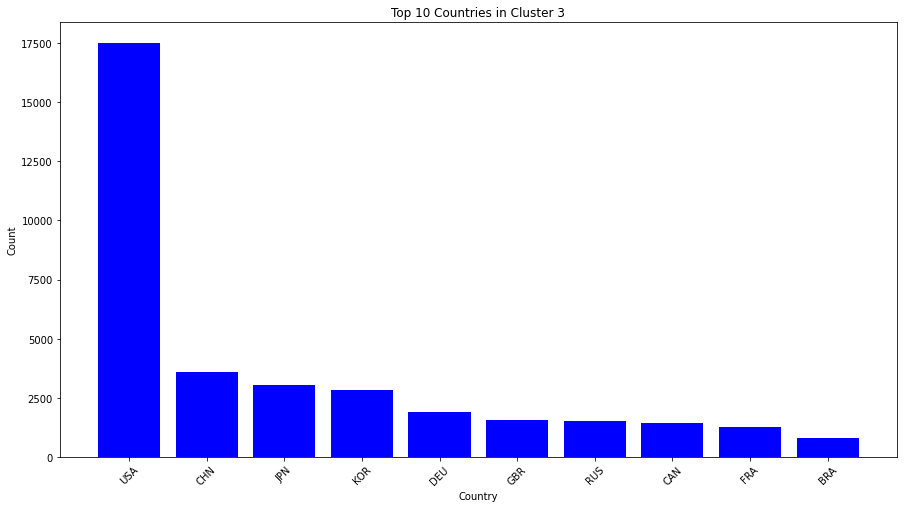

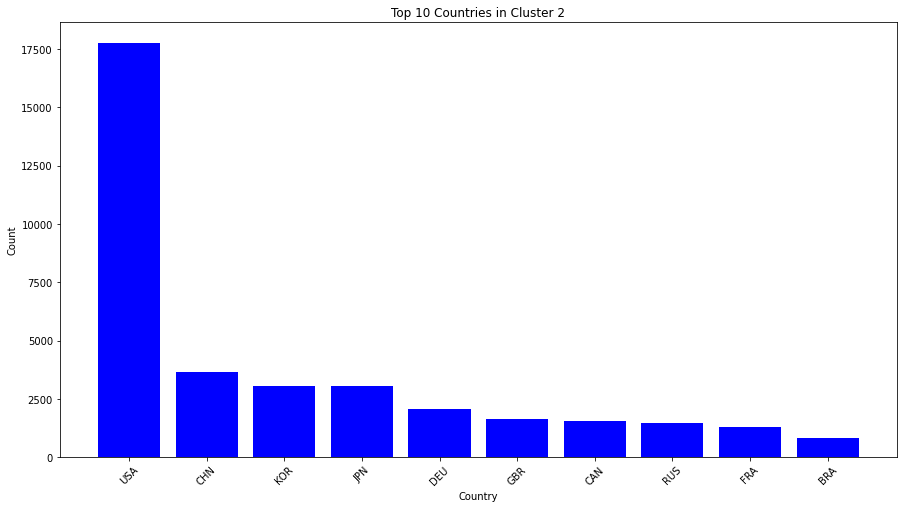

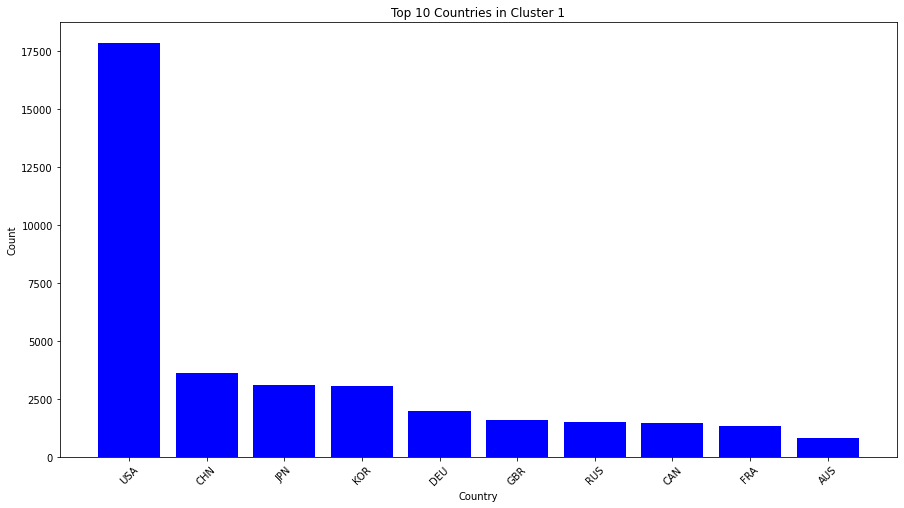

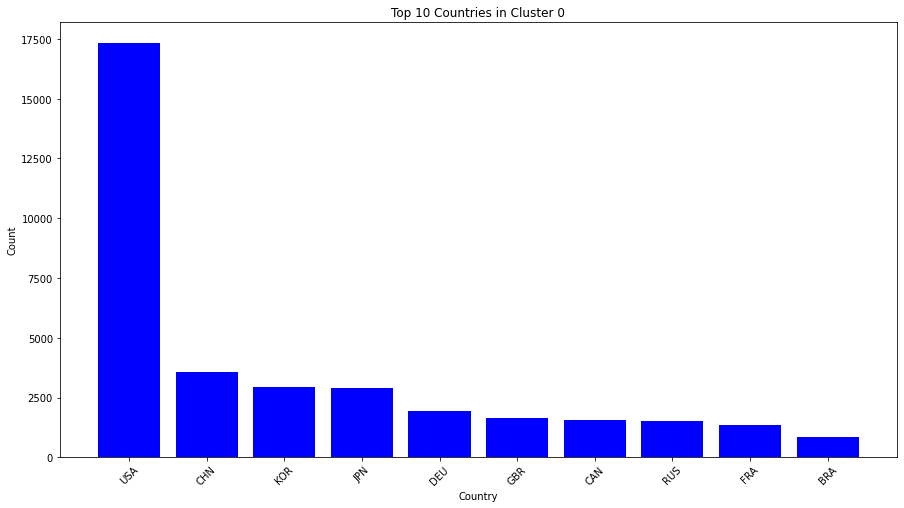

In [0]:
# Group data points by cluster and 'cca3' variable
cluster_profile = df_kmeans.groupby('prediction', 'cca3').count().sort(desc('prediction'))

# Collect the data to the driver node and convert it to Pandas DataFrame
cluster_profile = cluster_profile.toPandas()

# Create separate lists for clusters
clusters = cluster_profile['prediction'].unique()

# Number of top countries to display in each cluster
top_countries = 10

# Plot the distribution of countries within each cluster
for cluster in clusters:
    cluster_data = cluster_profile[cluster_profile['prediction'] == cluster]
    cluster_data = cluster_data.sort_values(by='count', ascending=False)
    
    # Limit the data to the top N countries
    cluster_data = cluster_data.head(top_countries)
    
    plt.figure(figsize=(15, 8))  # Increased figure size
    plt.bar(cluster_data['cca3'], cluster_data['count'], color='blue')
    plt.xlabel('Country')
    plt.ylabel('Count')
    plt.title(f'Top {top_countries} Countries in Cluster {cluster}')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.show()


### The next code generates a cluster profile summary by grouping data points based on the cluster label and the 'cca3' variable (country code). The resulting summary is displayed in a tabular format using the tabulate library.


In [0]:
from tabulate import tabulate
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import desc

from pyspark.sql.functions import desc

# Group data points by cluster and 'cca3' variable
cluster_profile = df_kmeans.groupby('prediction', 'cca3').count().sort(desc('prediction'))

# Create a DataFrame to display the table
display_df = cluster_profile.withColumnRenamed("prediction", "Cluster").withColumnRenamed("cca3", "Country").withColumnRenamed("count", "Count")

# Get the unique clusters
clusters = display_df.select("Cluster").distinct().rdd.flatMap(lambda x: x).collect()

# Loop over the clusters and display each one
for cluster in clusters:
    print(f"Cluster {cluster}")
    display_df.filter(display_df.Cluster == cluster).show()




Cluster 1
+-------+-------+-----+
|Cluster|Country|Count|
+-------+-------+-----+
|      1|    ISL|   10|
|      1|    TCA|    1|
|      1|    REU|    4|
|      1|    SGP|  253|
|      1|    AGO|   13|
|      1|    OMN|   10|
|      1|    ARE|   36|
|      1|    CRI|   32|
|      1|    SEN|    9|
|      1|    NIC|   10|
|      1|    HRV|   38|
|      1|    ISR|  179|
|      1|    PRI|   73|
|      1|    DNK|  276|
|      1|    BLR|   25|
|      1|    ROU|  297|
|      1|    LUX|   23|
|      1|    POL|  699|
|      1|    PAN|   31|
|      1|    CYP|   26|
+-------+-------+-----+
only showing top 20 rows

Cluster 3
+-------+-------+-----+
|Cluster|Country|Count|
+-------+-------+-----+
|      3|    CYM|    4|
|      3|    NIC|   15|
|      3|    NOR|  344|
|      3|    KOR| 2830|
|      3|    IRL|  108|
|      3|    GRC|  111|
|      3|    GRD|    5|
|      3|    MUS|   12|
|      3|    NPL|    6|
|      3|    DNK|  306|
|      3|    LTU|   83|
|      3|    TTO|    8|
|      3|    KGZ| 